In [4]:
# # Run only once to extract dataset in drive
# !tar xvzf "/content/drive/MyDrive/Colab Notebooks/rotten_imdb.tar.gz" -C "/content/drive/MyDrive/Colab Notebooks/"

In [6]:
!pip install word2vec
!pip install rouge-score
!pip install sumy

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import os
import random
import string
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split as tts
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sklearn.model_selection import StratifiedKFold, KFold
from sumy.parsers.plaintext import PlaintextParser
import matplotlib.pyplot as plt
from sumy.nlp.tokenizers import Tokenizer
from rouge_score import rouge_scorer
import re
from nltk.tokenize import sent_tokenize
from scipy import spatial
import networkx as nx

import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
polarity_dir = '/content/drive/MyDrive/Colab Notebooks/txt_sentoken'
imdb_train_dir   = '/content/drive/MyDrive/Colab Notebooks/aclImdb/train'
imdb_test_dir    = '/content/drive/MyDrive/Colab Notebooks/aclImdb/test'
subjective_dir  = '/content/drive/MyDrive/Colab Notebooks/quote.tok.gt9.5000'
objective_dir   =  '/content/drive/MyDrive/Colab Notebooks/plot.tok.gt9.5000'

# **Preprocessing**

In [11]:
def remove_html_tags(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def preprocessing(dir_path):
  category = ['pos','neg']
  documents = []
  for cat in category:
    print(cat)
    dir_curr = dir_path + '/' + cat
    file_list = [f for f in os.listdir(dir_curr) ]
    i = 0
    for file_name in file_list:
      i += 1
      file = open(dir_curr + '/' + file_name, 'r')
      text = file.read()
      text = remove_html_tags(text)
      # text = remove_punctuations(text)
      text = text.split()
      documents.append((text,cat))
      file.close()
      if i%100 == 0:
        print(i)
  # print(len(documents))
  random.shuffle(documents)
  return documents

def get_simple_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


def clean_review(words):
  lemmatizer = WordNetLemmatizer()
  stops = set(stopwords.words('english'))
  punctuations = list(string.punctuation)
  stops.update(punctuations)
  output = []
  for w in words:
    if w.lower() not in stops:
      pos = pos_tag([w])
      clean_word = lemmatizer.lemmatize(w,pos = get_simple_pos(pos[0][1]))
      if clean_word.isalpha():
        output.append(clean_word.lower())
  return output

In [12]:
def subjectivity_dataset_preprocess(documents,path, subjective = True):
  f_s = open(path, 'r' , encoding="ISO-8859-1")
  sentences = f_s.read().split('\n')
  f_s.close()

  if subjective:
    cat = 'subjective'
  else:
    cat = 'objective'

  for sent in range(0,len(sentences)-1):
    text = remove_html_tags(sentences[sent])
    text = text.split()
    documents.append((text,cat))

  random.shuffle(documents)
  return documents

# Feature Extraction

In [13]:
def feature_extraction(X_train, X_test, n_gram = 'unigram'):
  if n_gram == 'unigram':
    count_vec = CountVectorizer(max_features = 2000,ngram_range = (1,1))
  elif n_gram == 'bigram':
    count_vec = CountVectorizer(max_features = 2000,ngram_range = (2,2))
  elif n_gram == 'both':
    count_vec = CountVectorizer(max_features = 2000,ngram_range = (1,2))

  X_train_features = count_vec.fit_transform(X_train)
  X_test_features = count_vec.transform(X_test)

  return X_train_features, X_test_features

In [14]:
def feature_extraction_tfidf(X_train, X_test, n_gram = 'unigram'):
  if n_gram == 'unigram':
    count_vec = TfidfVectorizer(max_features = 2000,ngram_range = (1,1))
  elif n_gram == 'bigram':
    count_vec = TfidfVectorizer(max_features = 2000,ngram_range = (2,2))
  elif n_gram == 'both':
    count_vec = TfidfVectorizer(max_features = 2000,ngram_range = (1,2))
  
  X_train_features = count_vec.fit_transform(X_train)
  X_test_features = count_vec.transform(X_test)

  return X_train_features, X_test_features

In [15]:
# for imdb dataset split = False
def split_train_test(documents, split = True):
  categories = [category for document,category in documents]
  text_documents = [" ".join(document) for document,category in documents]
  if split:
      X_train, X_test, Y_train, Y_test = tts(text_documents, categories, test_size = 0.3)
      return X_train, X_test,Y_train,Y_test
  else:
      return text_documents,categories

# Review Classification

In [ ]:
polarity_doc = preprocessing(polarity_dir)

In [ ]:
imdb_train_doc = preprocessing(imdb_train_dir)

In [ ]:
imdb_test_doc = preprocessing(imdb_test_dir)

In [30]:
subjectivity_dataset_list = []
subjectivity_dataset_list = subjectivity_dataset_preprocess(subjectivity_dataset_list, subjective_dir)

In [31]:
subjectivity_dataset_list = subjectivity_dataset_preprocess(subjectivity_dataset_list, objective_dir, subjective=False)

In [32]:
subjectivity_dataset = [(clean_review(document),category) for document,category in subjectivity_dataset_list]

In [33]:
documents_polarity_dataset = [(clean_review(document),category) for document,category in polarity_doc]

In [18]:
imdb_train_dataset = [(clean_review(document),category) for document,category in imdb_train_doc]

In [19]:
imdb_test_dataset = [(clean_review(document),category) for document,category in imdb_test_doc]

In [34]:
X_train_s, X_test_s, Y_train_s, Y_test_s = split_train_test(subjectivity_dataset)

In [35]:
X_train_p, X_test_p, Y_train_p, Y_test_p = split_train_test(documents_polarity_dataset)

In [20]:
X_train_imdb, Y_train_imdb = split_train_test(imdb_train_dataset, split = False)

In [21]:
X_test_imdb, Y_test_imdb = split_train_test(imdb_test_dataset, split = False)

## Naive Bayes

In [102]:
Naive_Bayes_accuracies = {
    "Features" : ["Unigram","Bigram","Unigram+Bigram",'Unigram+TI-IDF', 'Bigram+TI-IDF', 'Unigram+Bigram+TI-IDF'],
    "PL04" : [],
    "imdb" : [],
    "subjectivity" : []
}

In [51]:
def alpha_vs_accuracy(xpoints, ypoints, ngram):
  plt.xticks(xpoints)
  plt.xlabel("alpha")
  plt.ylabel("accuracy")
  plt.title("alpha VS Accuracy " + ngram)
  plt.plot(xpoints, ypoints)
  plt.show()

In [52]:
'''
In StratifiedKFold The folds are made by preserving the percentage of samples for each class.
'''
    
def k_fold_cross_valid(X, y, folds, ngram):
    alpha_values = [1,2,3,4,5,6,7,8,9,10]
    accuracies   = []
    skf = StratifiedKFold(n_splits=folds)
    for val in alpha_values:
      sum = 0
      for train_index, test_index in skf.split(X, y):
          X_train, X_test = X[train_index], X[test_index]
          y_train, y_test = y[train_index], y[test_index]
          X_train_features, X_test_features = feature_extraction(X_train, X_test,n_gram = ngram)
          clf = MultinomialNB(alpha=val)
          clf.fit(X_train_features.todense(), y_train)
          y_pred = clf.predict(X_test_features.todense())
          acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
          sum += acc
      average = sum/folds
      accuracies.append(average)
      # print(ngram)
      # print('alpha:',val,' Accuracies:',average)
    alpha_vs_accuracy(alpha_values, accuracies,ngram)

1.   **Polarity Dataset**



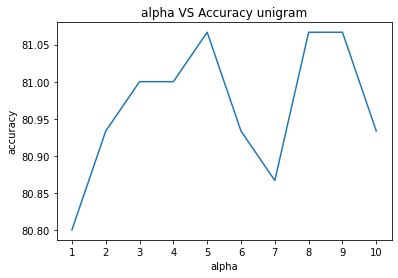

In [ ]:
# 10-fold cross validation n_gram = unigram
k_fold_cross_valid(np.array(X_train_p), np.array(Y_train_p),10,'unigram')

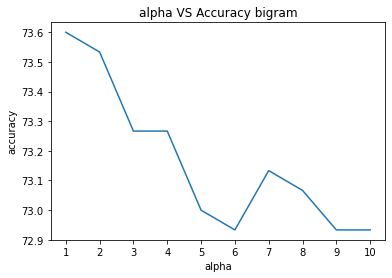

In [ ]:
# 10-fold cross validation n_gram = Bigram
k_fold_cross_valid(np.array(X_train_p), np.array(Y_train_p),10,'bigram')

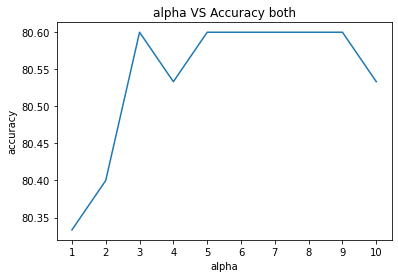

In [ ]:
# 10-fold cross validation n_gram = unigram + Bigram
k_fold_cross_valid(np.array(X_train_p), np.array(Y_train_p),10,'both')

**Unigram**

In [ ]:
X_train_features, X_test_features = feature_extraction(X_train_p, X_test_p)
clf = MultinomialNB(alpha=5)
clf.fit(X_train_features.todense(), Y_train_p)
y_pred_test = clf.predict(X_test_features.todense())
unigram_polarity_acc = accuracy_score(Y_test_p, y_pred_test, normalize=True) * float(100)
Naive_Bayes_accuracies['PL04'].append(unigram_polarity_acc)
print('Test accuracy is',(unigram_polarity_acc))

Test accuracy is 79.0


**Bigram**

In [ ]:
X_train_features, X_test_features = feature_extraction(X_train_p, X_test_p, n_gram='bigram')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features.todense(), Y_train_p)
y_pred_test = clf.predict(X_test_features.todense())
bigram_polarity_acc = accuracy_score(Y_test_p, y_pred_test, normalize=True) * float(100)
Naive_Bayes_accuracies['PL04'].append(bigram_polarity_acc)
print('Test accuracy is',(bigram_polarity_acc))

Test accuracy is 74.4


**Unigram + Bigram**

In [ ]:
X_train_features, X_test_features = feature_extraction(X_train_p, X_test_p, n_gram='both')
clf = MultinomialNB(alpha=6)
clf.fit(X_train_features.todense(), Y_train_p)

y_pred_test = clf.predict(X_test_features.todense())
ub_polarity_acc = accuracy_score(Y_test_p, y_pred_test, normalize=True) * float(100)
Naive_Bayes_accuracies['PL04'].append(ub_polarity_acc)
print('Test accuracy is',(ub_polarity_acc))

Test accuracy is 80.60000000000001


**Unigram + Tf-idf**

In [ ]:
X_train_features, X_test_features = feature_extraction_tfidf(X_train_p, X_test_p)
clf = MultinomialNB(alpha=5)
clf.fit(X_train_features.todense(), Y_train_p)

y_pred_test = clf.predict(X_test_features.todense())
ut_polarity_acc = accuracy_score(Y_test_p, y_pred_test, normalize=True) * float(100)
Naive_Bayes_accuracies['PL04'].append(ut_polarity_acc)
print('Test accuracy is',(ut_polarity_acc))

Test accuracy is 78.8


**Bigram + Tf-idf**

In [ ]:
X_train_features, X_test_features = feature_extraction_tfidf(X_train_p, X_test_p, n_gram='bigram')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features.todense(), Y_train_p)

y_pred_test = clf.predict(X_test_features.todense())
bt_polarity_acc = accuracy_score(Y_test_p, y_pred_test, normalize=True) * float(100)
Naive_Bayes_accuracies['PL04'].append(bt_polarity_acc)
print('Test accuracy is',(bt_polarity_acc))

Test accuracy is 77.0


**Unigram + Bigram + Tf-idf**

In [ ]:
X_train_features, X_test_features = feature_extraction_tfidf(X_train_p, X_test_p, n_gram='both')
clf = MultinomialNB(alpha=6)
clf.fit(X_train_features.todense(), Y_train_p)

y_pred_test = clf.predict(X_test_features.todense())
but_polarity_acc = accuracy_score(Y_test_p, y_pred_test, normalize=True) * float(100)
Naive_Bayes_accuracies['PL04'].append(but_polarity_acc)
print('Test accuracy is',(but_polarity_acc))

Test accuracy is 78.8


2.   **IMDB Dataset**

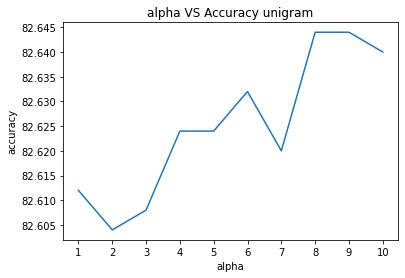

In [ ]:
# 10-fold cross validation IMDB n_gram = unigram
k_fold_cross_valid(np.array(X_train_imdb), np.array(Y_train_imdb), 10, 'unigram')

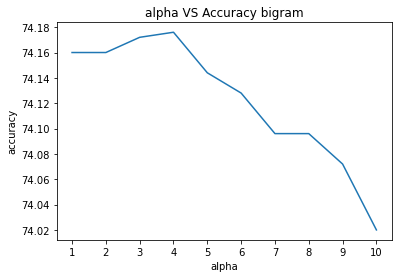

In [ ]:
# 10-fold cross validation IMDB n_gram = bigram
k_fold_cross_valid(np.array(X_train_imdb), np.array(Y_train_imdb), 10, 'bigram')

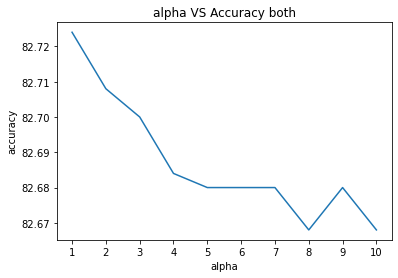

In [ ]:
# 10-fold cross validation IMDB n_gram = unigram + bigram
k_fold_cross_valid(np.array(X_train_imdb), np.array(Y_train_imdb), 10, 'both')

**Unigram**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction(X_train_imdb, X_test_imdb)
clf = MultinomialNB(alpha=8)
clf.fit(X_train_features_imdb.todense(), Y_train_imdb)

y_pred_test_imdb = clf.predict(X_test_features_imdb.todense())
unigram_imdb_acc = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Naive_Bayes_accuracies['imdb'].append(unigram_imdb_acc)
print('Test accuracy is',(unigram_imdb_acc))

Test accuracy is 82.272


**Bigram**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction(X_train_imdb, X_test_imdb, n_gram="bigram")
clf = MultinomialNB(alpha=4)
clf.fit(X_train_features_imdb.todense(), Y_train_imdb)

y_pred_test_imdb = clf.predict(X_test_features_imdb.todense())
bigram_imdb_acc = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Naive_Bayes_accuracies['imdb'].append(bigram_imdb_acc)
print('Test accuracy is',(bigram_imdb_acc))

Test accuracy is 74.432


**Unigram + Bigram**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction(X_train_imdb, X_test_imdb, n_gram="both")
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_imdb.todense(), Y_train_imdb)

y_pred_test_imdb = clf.predict(X_test_features_imdb.todense())
ub_imdb_acc = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Naive_Bayes_accuracies['imdb'].append(ub_imdb_acc)
print('Test accuracy is',(ub_imdb_acc))

Test accuracy is 82.65599999999999


**Unigram + Tf-idf**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction_tfidf(X_train_imdb, X_test_imdb)
clf = MultinomialNB(alpha=8)
clf.fit(X_train_features_imdb.todense(), Y_train_imdb)

y_pred_test_imdb = clf.predict(X_test_features_imdb.todense())
ut_imdb_acc = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Naive_Bayes_accuracies['imdb'].append(ut_imdb_acc)
print('Test accuracy is',(ut_imdb_acc))

Test accuracy is 82.604


**Bigram + Tf-idf**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction_tfidf(X_train_imdb, X_test_imdb,n_gram='bigram')
clf = MultinomialNB(alpha=4)
clf.fit(X_train_features_imdb.todense(), Y_train_imdb)

y_pred_test_imdb = clf.predict(X_test_features_imdb.todense())
bt_imdb_acc = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Naive_Bayes_accuracies['imdb'].append(bt_imdb_acc)
print('Test accuracy is',(bt_imdb_acc))

Test accuracy is 74.41600000000001


**Unigram + Bigram + Tf-idf**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction_tfidf(X_train_imdb, X_test_imdb,n_gram='both')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_imdb.todense(), Y_train_imdb)

y_pred_test_imdb = clf.predict(X_test_features_imdb.todense())
but_imdb_acc = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Naive_Bayes_accuracies['imdb'].append(but_imdb_acc)
print('Test accuracy is',(but_imdb_acc))

Test accuracy is 83.00800000000001


**Subjectivity dataset**

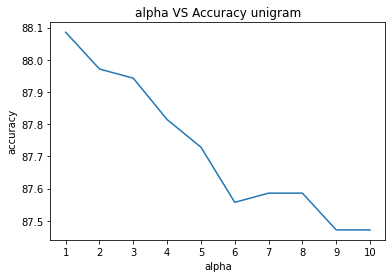

In [87]:
# 10-fold cross validation n_gram = unigram
k_fold_cross_valid(np.array(X_train_s), np.array(Y_train_s),10,'unigram')

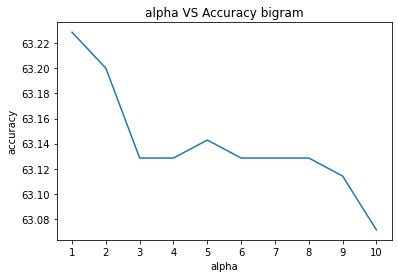

In [88]:
# 10-fold cross validation n_gram = Bigram
k_fold_cross_valid(np.array(X_train_s), np.array(Y_train_s),10,'bigram')

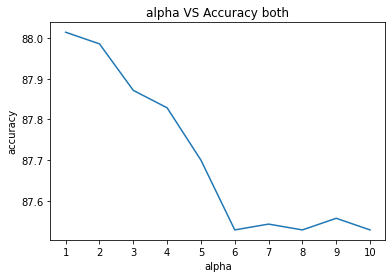

In [89]:
# 10-fold cross validation n_gram = unigram + Bigram
k_fold_cross_valid(np.array(X_train_s), np.array(Y_train_s),10,'both')

**Unigram**

In [90]:
X_train_features_sub, X_test_features_sub = feature_extraction(X_train_s, X_test_s)
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_sub.todense(), Y_train_s)

y_pred_test_s = clf.predict(X_test_features_sub.todense())
unigram_sub_acc = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Naive_Bayes_accuracies['subjectivity'].append(unigram_sub_acc)
print('Test accuracy is',(unigram_sub_acc))

Test accuracy is 86.6


**Bigram**

In [93]:
X_train_features_sub, X_test_features_sub = feature_extraction(X_train_s, X_test_s, n_gram = 'bigram')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_sub.todense(), Y_train_s)

y_pred_test_s = clf.predict(X_test_features_sub.todense())
bigram_sub_acc = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Naive_Bayes_accuracies['subjectivity'].append(bigram_sub_acc)
print('Test accuracy is',(bigram_sub_acc))

Test accuracy is 62.866666666666674


**Unigram + Bigram**

In [94]:
X_train_features_sub, X_test_features_sub = feature_extraction(X_train_s, X_test_s, n_gram = 'both')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_sub.todense(), Y_train_s)

y_pred_test_s = clf.predict(X_test_features_sub.todense())
ub_sub_acc = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Naive_Bayes_accuracies['subjectivity'].append(ub_sub_acc)
print('Test accuracy is',(ub_sub_acc))

Test accuracy is 86.53333333333333


**Unigram + TI-IDF**

In [97]:
X_train_features_sub, X_test_features_sub = feature_extraction_tfidf(X_train_s, X_test_s)
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_sub.todense(), Y_train_s)

y_pred_test_s = clf.predict(X_test_features_sub.todense())
unigram_sub_acc_ti = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Naive_Bayes_accuracies['subjectivity'].append(unigram_sub_acc_ti)
print('Test accuracy is',(unigram_sub_acc_ti))

Test accuracy is 86.83333333333333


**Bigram + TI-IDF**

In [100]:
X_train_features_sub, X_test_features_sub = feature_extraction_tfidf(X_train_s, X_test_s, n_gram='bigram')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_sub.todense(), Y_train_s)

y_pred_test_s = clf.predict(X_test_features_sub.todense())
bigram_sub_acc_ti = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Naive_Bayes_accuracies['subjectivity'].append(bigram_sub_acc_ti)
print('Test accuracy is',(bigram_sub_acc_ti))

Test accuracy is 62.56666666666667


**Unigram + Bigram + TI-IDF**

In [101]:
X_train_features_sub, X_test_features_sub = feature_extraction_tfidf(X_train_s, X_test_s, n_gram='both')
clf = MultinomialNB(alpha=1)
clf.fit(X_train_features_sub.todense(), Y_train_s)

y_pred_test_s = clf.predict(X_test_features_sub.todense())
ub_sub_acc_ti = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Naive_Bayes_accuracies['subjectivity'].append(ub_sub_acc_ti)
print('Test accuracy is',(ub_sub_acc_ti))

Test accuracy is 86.66666666666667


In [104]:
pd.DataFrame(Naive_Bayes_accuracies)

,Features,PL04,imdb,subjectivity
0,Unigram,79.0,82.272,86.600000
1,Bigram,74.4,74.432,62.866600
2,Unigram+Bigram,80.6,82.656,86.533333
3,Unigram+TI-IDF,78.8,82.604,86.833333
4,Bigram+TI-IDF,77.0,74.416,62.566667
5,Unigram+Bigram+TI-IDF,78.8,83.008,86.666667


## Decison Tree

In [105]:
Decision_tree_accuracy = {
    "Criteria" : ['Gini' , 'Entropy'],
    "PL04" : [],
    "imdb" : [],
    "Subjectivity" : []
}

**Polarity Dataset**

In [ ]:
# X_train_features, X_test_features
X_train_features_p, X_test_features_p = feature_extraction(X_train_p, X_test_p)
decision_tree_polarity = DecisionTreeClassifier() # Gini
decision_tree_polarity.fit(X_train_features_p, Y_train_p)
y_pred_test_p = decision_tree_polarity.predict(X_test_features_p)
dt_acc_gini = accuracy_score(Y_test_p, y_pred_test_p, normalize=True) * float(100)
Decision_tree_accuracy['PL04'].append(dt_acc_gini)
print('Test accuracy is',(dt_acc_gini))

Test accuracy is 65.2


In [ ]:
# X_train_features, X_test_features
X_train_features_p, X_test_features_p = feature_extraction(X_train_p, X_test_p)
decision_tree_polarity = DecisionTreeClassifier(criterion = 'entropy')
decision_tree_polarity.fit(X_train_features_p, Y_train_p)
y_pred_test_p = decision_tree_polarity.predict(X_test_features_p)
dt_acc_entropy = accuracy_score(Y_test_p, y_pred_test_p, normalize=True) * float(100)
Decision_tree_accuracy['PL04'].append(dt_acc_entropy)
print('Test accuracy is',(dt_acc_entropy))

Test accuracy is 60.199999999999996


**Imdb Dataset**

In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction(X_train_imdb, X_test_imdb)
decision_tree_imdb = DecisionTreeClassifier(criterion = 'entropy')
decision_tree_polarity.fit(X_train_features_imdb, Y_train_imdb)
y_pred_test_imdb = decision_tree_polarity.predict(X_test_features_imdb)
dt_acc_entropy_imdb = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Decision_tree_accuracy['imdb'].append(dt_acc_entropy_imdb)
print('Test accuracy is',(dt_acc_entropy_imdb))

Test accuracy is 70.06


In [ ]:
X_train_features_imdb, X_test_features_imdb = feature_extraction(X_train_imdb, X_test_imdb)
decision_tree_imdb = DecisionTreeClassifier()
decision_tree_polarity.fit(X_train_features_imdb, Y_train_imdb)
y_pred_test_imdb = decision_tree_polarity.predict(X_test_features_imdb)
dt_acc_gini_imdb = accuracy_score(Y_test_imdb, y_pred_test_imdb, normalize=True) * float(100)
Decision_tree_accuracy['imdb'].append(dt_acc_gini_imdb)
print('Test accuracy is',(dt_acc_gini_imdb))

Test accuracy is 69.892


**Subjectivity Dataset**

In [108]:
# X_train_features, X_test_features
X_train_features_s, X_test_features_s = feature_extraction(X_train_s, X_test_s)
decision_tree_subjectivity = DecisionTreeClassifier() # Gini
decision_tree_subjectivity.fit(X_train_features_s, Y_train_s)
y_pred_test_s = decision_tree_subjectivity.predict(X_test_features_s)
dt_acc_gini_s = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Decision_tree_accuracy['PL04'].append(dt_acc_gini)
print('Test accuracy is',(dt_acc_gini_s))

Test accuracy is 75.76666666666667


In [109]:
# X_train_features, X_test_features
X_train_features_s, X_test_features_s = feature_extraction(X_train_s, X_test_s)
decision_tree_subjectivity = DecisionTreeClassifier(criterion='entropy')
decision_tree_subjectivity.fit(X_train_features_s, Y_train_s)
y_pred_test_s = decision_tree_subjectivity.predict(X_test_features_s)
dt_acc_gini_e = accuracy_score(Y_test_s, y_pred_test_s, normalize=True) * float(100)
Decision_tree_accuracy['PL04'].append(dt_acc_gini_e)
print('Test accuracy is',(dt_acc_gini_e))

Test accuracy is 77.36666666666666


In [111]:
pd.DataFrame(Decision_tree_accuracy)

,Criteria,PL04,imdb,Subjectivity
0,Gini,65.2,70.060,75.766667
1,Entropy,60.2,69.892,77.366667


## SVM

In [112]:
svm_acc = {
    "Dataset" : ["PL04" , "IMDB", "subjectivity"],
    "Accuracy" : None
}

**Polarity Dataset**

In [ ]:
x_train, x_test = feature_extraction(X_train_p, X_test_p)
svm = LinearSVC()
svm.fit(x_train, Y_train_p)
y_pred = svm.predict(x_test)
svm_polarity_acc = accuracy_score(Y_test_p, y_pred, normalize=True) * float(100)
print('Test accuracy is',(svm_polarity_acc))

Test accuracy is 78.60000000000001


**IMDB**

In [ ]:
x_train_imdb, x_test_imdb = feature_extraction(X_train_imdb, X_test_imdb)
svm = LinearSVC()
svm.fit(x_train_imdb, Y_train_imdb)
y_pred = svm.predict(x_test_imdb)
svm_imdb_acc = accuracy_score(Y_test_imdb, y_pred, normalize=True) * float(100)
print('Test accuracy is',(svm_imdb_acc))

Test accuracy is 83.852


**Subjectivity Dataset**

In [114]:
x_train_s, x_test_s = feature_extraction(X_train_s, X_test_s)
svm = LinearSVC()
svm.fit(x_train_s, Y_train_s)
y_pred_s = svm.predict(x_test_s)
svm_sub_acc = accuracy_score(Y_test_s, y_pred_s, normalize=True) * float(100)
print('Test accuracy is',(svm_sub_acc))

Test accuracy is 83.43333333333334


In [115]:
svm_acc["Accuracy"] = [svm_polarity_acc, svm_imdb_acc,svm_sub_acc]
pd.DataFrame(svm_acc)

,Dataset,Accuracy
0,PL04,78.600000
1,IMDB,83.852000
2,subjectivity,83.433333


## CNN

In [26]:
def cnn(X_train_p, X_test_p, Y_train_p, Y_test_p, epochs):

    train_tokenizer = Tokenizer(num_words=2000,oov_token="unk")
    train_tokenizer.fit_on_texts(X_train_p)

    ##
    test_tokenizer = Tokenizer(num_words=2000,oov_token="unk")
    test_tokenizer.fit_on_texts(X_test_p)

    ##
    x_train = np.array(train_tokenizer.texts_to_sequences(X_train_p))

    ##
    x_test = np.array(test_tokenizer.texts_to_sequences(X_test_p) )

    ##
    max_len = len(max(x_train,key=len))

    ##
    x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
    x_test  = pad_sequences(x_test, padding='post', maxlen=max_len)

    ##
    label_encoder = LabelEncoder()

    y_train = label_encoder.fit_transform(Y_train_p)
    y_train = np.asarray( tf.keras.utils.to_categorical(y_train))
    y_test = label_encoder.fit_transform(Y_test_p)
    y_test = np.asarray( tf.keras.utils.to_categorical(y_test))
    x_train.shape, x_test.shape, y_train.shape, y_test.shape

    ##
    max_features =2000
    embedding_dim =64
    sequence_length = max_len

    model = tf.keras.Sequential()

    model.add(Embedding(max_features +1, embedding_dim, input_length=sequence_length))                                    

    model.add(Conv1D(512,3, activation='relu'))                               

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    ##
    model.fit(x_train, y_train, epochs=epochs, verbose=2)

    ##
    acc = model.evaluate(x_test, y_test, verbose=0)

    return acc

In [39]:
cnn_accuracy = {
    "Dataset" : ["subjectivity", "polarity", "Imdb"],
    "Accuracy" : None
}

**Subjectivity Dataset**

In [36]:
sub_acc = cnn(X_train_s, X_test_s, Y_train_s, Y_test_s,10)
sub_acc

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 47, 64)            128064    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 512)           98816     
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 292,802
Trainable params: 292,802
Non-trainable params: 0
________________________________________________

[4.28924036026001, 0.5403333306312561]

**Polarity Dataset**

In [37]:
polarity_acc = cnn(X_train_p, X_test_p, Y_train_p, Y_test_p,10)
polarity_acc

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1301, 64)          128064    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1299, 512)         98816     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 292,802
Trainable params: 292,802
Non-trainable params: 0
________________________________________________

[1.892805814743042, 0.4933333396911621]

**Imdb dataset**

In [38]:
imdb_acc = cnn(X_train_imdb, X_test_imdb, Y_train_imdb, Y_test_imdb,10)
imdb_acc

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1179, 64)          128064    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1177, 512)         98816     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 292,802
Trainable params: 292,802
Non-trainable params: 0
________________________________________________

[2.7559762001037598, 0.5646799802780151]

In [41]:
cnn_accuracy['Accuracy'] = [sub_acc[1], polarity_acc[1], imdb_acc[1]]
pd.DataFrame(cnn_accuracy)

,Dataset,Accuracy
0,subjectivity,0.540333
1,polarity,0.493333
2,Imdb,0.564680


# Review Summarization

In [ ]:
def build_similarity_matrix(sentences,sentence_vectors):
  sim_mat = np.zeros([len(sentences), len(sentences)])
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      if i != j:
        sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]
  return sim_mat

In [ ]:
def preprocess(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    doc = word_tokenize(text)
    doc = clean_review(doc)
    return doc

In [ ]:
def document_vector(model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    if len(doc) > 0:
        return np.mean(model[doc], axis=0)
    else:
      return np.array([])

In [ ]:
def make_sentence_vector(text):
  
  sentences = sent_tokenize(text)
  # print(len(sentences))
  filter = []
  x = []
  y = []
  
  for sent in sentences:
    x.append(preprocess(sent))

  return word_2_vec(x)
  model = Word2Vec(x,min_count=1)

  for i,doc in enumerate(x):
    p = document_vector(model, doc)
    if len(p) > 0:
      y.append(p)
      filter.append(sentences[i])

  return np.array(y), np.array(filter)

In [ ]:
'''
Builds graph using similarity matrix.
Nodes represents a sentence.
If the similarity between two sentence lies between (0,0.5] then there will be
a edge between those nodes with weight = cosine_similarity between those
sentences.
'''
def build_graph(similarity_matrix):
  x, y = similarity_matrix.shape
  adj_matrix = np.zeros((x,y))
  for i in range(x):
    for j in range(y):
      if i != j:
        sim_value = similarity_matrix[i][j]
        if sim_value > 0  and sim_value <= 0.5:
          adj_matrix[i][j] = sim_value
  return adj_matrix

In [ ]:
def weight_rank_algo(adj_matrix,d,iterations=5):
  x, y = adj_matrix.shape
  wgra = np.ones(x)
  for iter in range(iterations):
    node_converged = 0
    for i in range(x):
        sum = 0
        for j in range(y):
          sum = sum + wgra[j]*adj_matrix[j][i]/np.sum(adj_matrix[j])
        if((((1-d) + d*sum) - wgra[i]) <=  0.0001):
          # print('converge:',i)
          node_converged = node_converged + 1
        wgra[i] = (1-d) + d*sum
    if node_converged == x:
      print('All nodes converged at iteration :',iter)
      break
    # print(wgra)
  return wgra

# (0.0001)

In [ ]:
def write_summary_tofile(summary,filename):
  dir_path = '/content/drive/MyDrive/Colab Notebooks/summaries/'
  summary_file = dir_path + filename

  with open(summary_file,'w') as out:
    out.write(summary)

  print('written:',summary_file)

In [ ]:
'''
Creates summary by getting highest ranked sentences.
'''
def generate_summary(wgra, sentences,top):
  rang = min(len(sentences)-1,top)
  highest_rank = np.argpartition(-wgra,range(rang+1))
  summary = ""
  for i in range(0,rang):
    summary = summary + sentences[highest_rank[i]] + "\n"
  return summary

In [ ]:
'''
Creates summary using lexrank.
'''
def get_lexrank_summary(text, top):
  parser = PlaintextParser.from_string(text,Tokenizer("english"))
  summarizer_lex = LexRankSummarizer()
  summary= summarizer_lex(parser.document, top)
  lex_summary=""
  for sentence in summary:
      lex_summary+=str(sentence)  
  return lex_summary

In [ ]:
'''
Creates summary using textrank
'''
def get_textrank_summary(text, top):

  parser = PlaintextParser.from_string(text,Tokenizer("english"))
  summarizer = TextRankSummarizer()
  summary =summarizer(parser.document,top)
  text_summary=""
  for sentence in summary:
      text_summary+=str(sentence)
  return text_summary

In [ ]:
'''
Reads every input file, and calculates similarity matrix, adjacency matrix, and ranks of node in graph.
calculates rogue score between reference summary and generated summary.

Here reference summary is generated using lexrank/Textrank
'''
def summarize(dir_path, compare_with,top=20,iter=10, write=False):
  category = ['pos','neg']
  rogue1 = [0,0,0] # precision, recall, fmeasure
  rogue2 = [0,0,0]
  for cat in category:
    print(cat)
    dir_curr = dir_path + '/' + cat
    file_list = [f for f in os.listdir(dir_curr) ]
    for file_name in file_list:
      file = open(dir_curr + '/' + file_name, 'r')
      text = file.read()
      sentences_vector, sentences = make_sentence_vector(text)
      similarity_matrix = build_similarity_matrix(sentences,sentences_vector)
      # print('similarity_matrix:',similarity_matrix.shape)
      adj_matrix = build_graph(similarity_matrix)
      # print('adj_matrix:',adj_matrix.shape)
      wgra = weight_rank_algo(adj_matrix,0.85,iterations=iter)
      # print('wgra:',wgra.shape)
      summary = generate_summary(wgra,sentences,top)

      ref_summary = ''

      if compare_with == 'lexrank': 
        ref_summary = get_lexrank_summary(text,top)
      elif compare_with == 'textrank':
        ref_summary = get_textrank_summary(text,top)

      scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'])
      scores = scorer.score(ref_summary,summary)
      # print(scores)
      rogue1[0] = rogue1[0] + scores['rouge1'].precision
      rogue1[1] = rogue1[1] + scores['rouge1'].recall
      rogue1[2] = rogue1[2] + scores['rouge1'].fmeasure
      rogue2[0] = rogue2[0] + scores['rouge2'].precision
      rogue2[1] = rogue2[1] + scores['rouge2'].recall
      rogue2[2] = rogue2[2] + scores['rouge2'].fmeasure
      file.close()

      if write:
        write_summary_tofile(summary,file_name)
  return rogue1, rogue2

**Polarity Dataset**

In [ ]:
'''
Rouge-1 and Rouge-2 scores dictionary for creating dataframe for polarity dataset.
'''

Rouge_1_Score_polarity = {
    "Rouge_1_Score" : ["Precision","Recall", "F-score"],
    "Lexrank" : None,
    "Textrank" : None
}
Rouge_2_Score_polarity = {
    "Rouge_2_Score" : ["Precision","Recall", "F-score"],
    "Lexrank" : None,
    "Textrank" : None
}

In [ ]:
# compare polarity dataset with lexrank
rouge1_lex, rouge2_lex = summarize('/content/drive/MyDrive/Colab Notebooks/txt_sentoken','lexrank',15, write=True)

In [ ]:
# compare polarity dataset with textrank
rouge1_text, rouge2_text = summarize('/content/drive/MyDrive/Colab Notebooks/txt_sentoken','textrank',15)

In [ ]:
Rouge_1_Score_polarity["Lexrank"]  = np.array(rouge1_lex)/2000
Rouge_2_Score_polarity["Lexrank"]  = np.array(rouge2_lex)/2000
Rouge_1_Score_polarity["Textrank"] = np.array(rouge1_text)/2000
Rouge_2_Score_polarity["Textrank"] = np.array(rouge2_text)/2000

In [ ]:
pd.DataFrame(Rouge_1_Score_polarity)

,Rouge_1_Score,Lexrank,Textrank
0,Precision,0.724229,0.816529
1,Recall,0.734731,0.680255
2,F-score,0.726589,0.739065


In [ ]:
pd.DataFrame(Rouge_2_Score_polarity)

,Rouge_2_Score,Lexrank,Textrank
0,Precision,0.600731,0.706834
1,Recall,0.609685,0.594077
2,F-score,0.602877,0.643024


**Imdb Dataset**

In [ ]:
# compare imdb dataset with lexrank
rouge1_lex_imdb, rouge2_lex_imdb = summarize('/content/drive/MyDrive/Colab Notebooks/aclImdb/test','lexrank',15)

In [ ]:
# compare imdb dataset with textrank
rouge1_text_imdb, rouge2_text_imdb = summarize('/content/drive/MyDrive/Colab Notebooks/aclImdb/test','textrank',15)

In [ ]:
'''
Rouge-1 and Rouge-2 scores dictionary for creating dataframe for IMDB dataset.
'''

Rouge_1_Score_imdb = {
    "Rouge_1_Score" : ["Precision","Recall", "F-score"],
    "Lexrank" : None,
    "Textrank" : None
}
Rouge_2_Score_imdb = {
    "Rouge_2_Score" : ["Precision","Recall", "F-score"],
    "Lexrank" : None,
    "Textrank" : None
}

In [ ]:
Rouge_1_Score_imdb["Lexrank"]  = np.array(rouge1_lex_imdb)/25000
Rouge_2_Score_imdb["Lexrank"]  = np.array(rouge2_lex_imdb)/25000
Rouge_1_Score_imdb["Textrank"] = np.array(rouge1_text_imdb)/25000
Rouge_2_Score_imdb["Textrank"] = np.array(rouge2_text_imdb)/25000

In [ ]:
pd.DataFrame(Rouge_2_Score_imdb)

,Rouge_2_Score,Lexrank,Textrank
0,Precision,0.916467,0.934587
1,Recall,0.816423,0.816810
2,F-score,0.856988,0.866024


In [ ]:
pd.DataFrame(Rouge_1_Score_imdb)

,Rouge_1_Score,Lexrank,Textrank
0,Precision,0.954141,0.969713
1,Recall,0.852773,0.848892
2,F-score,0.894025,0.899629
